In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import geopy.distance
pd.options.mode.chained_assignment = None  # default='warn'
import time

In [12]:
## Load necessary data
G = pickle.load(open('data/revised_cleaning_results/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/revised_cleaning_results/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

In [13]:
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
 

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [14]:
df_nodes

,n,X,Y,geometry,Wkt,degree
8866165,8866165,5.382950,52.262284,"{'type': 'Point', 'coordinates': (5.3829497287...",POINT (5.3829497287695700 52.2622839331948015),2
B8920_B,B8920_B,5.954456,51.202796,"{'type': 'Point', 'coordinates': (5.9544561397...",POINT (5.9544561397793894 51.2027961195344616),2
B58191_A,B58191_A,6.940557,53.320616,"{'type': 'Point', 'coordinates': (6.9405567232...",POINT (6.9405567232651215 53.3206159483904614),2
B53266_A,B53266_A,5.770475,52.707727,"{'type': 'Point', 'coordinates': (5.7704750303...",POINT (5.7704750303644330 52.7077273261975066),2
B49641_B,B49641_B,6.720430,52.252350,"{'type': 'Point', 'coordinates': (6.7204298932...",POINT (6.7204298932146269 52.2523498416338228),2
...,...,...,...,...,...,...
8865818,8865818,4.447912,51.900094,"{'type': 'Point', 'coordinates': (4.4479120307...",POINT (4.4479120307381397 51.9000940107846986),2
8866159,8866159,5.785317,53.042667,"{'type': 'Point', 'coordinates': (5.7853165926...",POINT (5.7853165926755601 53.0426668480593975),2
B19662337_B,B19662337_B,6.390999,53.253098,"{'type': 'Point', 'coordinates': (6.3909988055...",POINT (6.3909988055204376 53.2530979538195126),2
Berth250,Berth250,5.437047,52.535158,"{'type': 'Point', 'coordinates': (5.4370472350...",POINT (5.4370472350224741 52.5351577154749592),2


In [15]:
nodes_to_keep = df_nodes.loc[(df_nodes.degree!=2)|(df_nodes.n.isin(harbour_nodes))]

In [16]:
keep = list(nodes_to_keep.n)+['8866429']

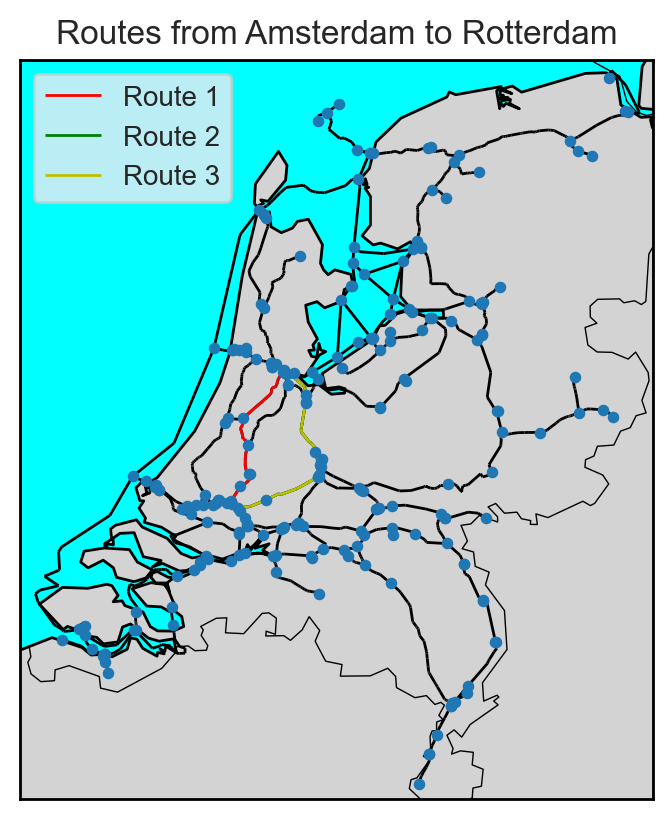

In [17]:
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(dpi=200)
m = Basemap(projection='merc',
            llcrnrlon=3.31497114423,
            llcrnrlat=50.803721015,
            urcrnrlon=7.09205325687,
            urcrnrlat=53.5104033474,
            lat_0=(3.31497114423 + 7.09205325687) / 2,
            lon_0=(50.8 + 53.5104033474) / 2,
            resolution='i'
            )
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#D3D3D3', lake_color='aqua')
m.drawcoastlines()
m.drawcountries()

pos_dict = {}
mx, my = m(df_nodes.X.values, df_nodes.Y.values)
for count, elem in enumerate(df_nodes.n):
    pos_dict[elem] = (mx[count], my[count])
# all edges related to route

nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)
K = G.subgraph(paths[('NLRTM', 'NLAMS', 0)])
nx.draw_networkx_edges(K, pos_dict, edge_color='r', label = 'Route 1')
H = G.subgraph(paths[('NLRTM', 'NLAMS', 1)])
nx.draw_networkx_edges(H, pos_dict, edge_color='g', label = 'Route 2')
H = G.subgraph(paths[('NLRTM', 'NLAMS', 2)])
nx.draw_networkx_edges(H, pos_dict, edge_color='y', label = 'Route 3')
plt.legend()
plt.title('Routes from Amsterdam to Rotterdam')
plt.show()

## Simplify graph

In [18]:
# create list to store new edges
new_edges = []

#loop over all routes
for key, route in paths.items():
    path_length = 0
    # print(key)
    # store all nodes that are still in G in the right order

    new_route = []
    for node in route:
        if node in keep:
            new_route.append(node)

    # change path to new route already
    paths[key] = new_route
    # print(new_route)
    sub_trips = [new_route[i:(i+2)] for i in range(len(new_route)-1)]
    # print(sub_trips)
    started_from = new_route[0]
    for sub_trip in sub_trips:
        origin=sub_trip[0]
        destination=sub_trip[1]
        path_length += nx.dijkstra_path_length(G, origin, destination, weight='length_m')
        if destination in new_route:
            if G.has_edge(started_from, destination):
                started_from = destination
                path_length = 0
            else:
                new_edges.append((origin, destination, path_length))
                started_from = destination
                path_length = 0


In [19]:
#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')


# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [20]:
df_nodes

,n,X,Y,geometry,Wkt,degree
8866165,8866165,5.382950,52.262284,"{'type': 'Point', 'coordinates': (5.3829497287...",POINT (5.3829497287695700 52.2622839331948015),2
B8920_B,B8920_B,5.954456,51.202796,"{'type': 'Point', 'coordinates': (5.9544561397...",POINT (5.9544561397793894 51.2027961195344616),2
B58191_A,B58191_A,6.940557,53.320616,"{'type': 'Point', 'coordinates': (6.9405567232...",POINT (6.9405567232651215 53.3206159483904614),2
B53266_A,B53266_A,5.770475,52.707727,"{'type': 'Point', 'coordinates': (5.7704750303...",POINT (5.7704750303644330 52.7077273261975066),2
B49641_B,B49641_B,6.720430,52.252350,"{'type': 'Point', 'coordinates': (6.7204298932...",POINT (6.7204298932146269 52.2523498416338228),2
...,...,...,...,...,...,...
8865818,8865818,4.447912,51.900094,"{'type': 'Point', 'coordinates': (4.4479120307...",POINT (4.4479120307381397 51.9000940107846986),2
8866159,8866159,5.785317,53.042667,"{'type': 'Point', 'coordinates': (5.7853165926...",POINT (5.7853165926755601 53.0426668480593975),2
B19662337_B,B19662337_B,6.390999,53.253098,"{'type': 'Point', 'coordinates': (6.3909988055...",POINT (6.3909988055204376 53.2530979538195126),2
Berth250,Berth250,5.437047,52.535158,"{'type': 'Point', 'coordinates': (5.4370472350...",POINT (5.4370472350224741 52.5351577154749592),2


In [21]:
G = G.subgraph(keep)
G = nx.Graph(G)
G.add_weighted_edges_from(new_edges,'length_m')

In [22]:
excluded_links = df_links.loc[(df_links.target.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))|(df_links.source.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))]
excluded_links = list(zip(list(excluded_links.source),list(excluded_links.target)))

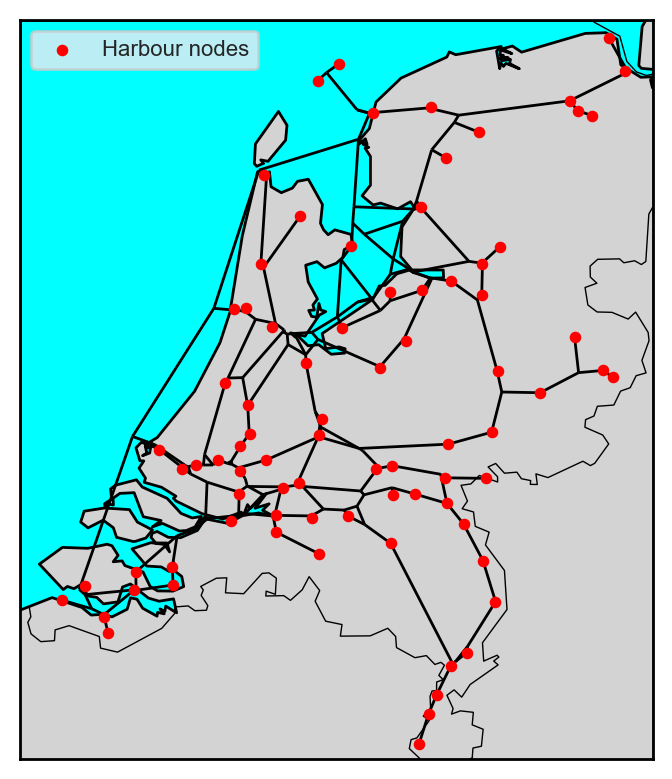

In [26]:
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(dpi=200)
m = Basemap(projection='merc',
            llcrnrlon=3.31497114423,
            llcrnrlat=50.803721015,
            urcrnrlon=7.09205325687,
            urcrnrlat=53.5104033474,
            lat_0=(3.31497114423 + 7.09205325687) / 2,
            lon_0=(50.8 + 53.5104033474) / 2,
            resolution='i'
            )
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#D3D3D3', lake_color='aqua')
m.drawcoastlines()
m.drawcountries()

pos_dict = {}
mx, my = m(df_nodes.X.values, df_nodes.Y.values)
for count, elem in enumerate(df_nodes.n):
    pos_dict[elem] = (mx[count], my[count])

nx.draw_networkx_edges(G, pos_dict)
# nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10, node_color='Blue', label='Intersections')
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='r', label='Harbour nodes')

# K = G.subgraph(paths[('NLIJM', 'NLMOE', 0)])
# nx.draw_networkx_edges(K, pos_dict, edge_color='b', label = 'Route 1, n=9')
# H = G.subgraph(paths[('NLIJM', 'NLMOE', 1)])
# nx.draw_networkx_edges(H, pos_dict, edge_color='g', label = 'Route 2, n=363')
# H = G.subgraph(paths[('NLIJM', 'NLMOE', 2)])
# nx.draw_networkx_edges(H, pos_dict, edge_color='y', label = 'Route 3, n=53')
# X = G.subgraph(paths[('NLIJM', 'NLMOE', 2)])
# nx.draw_networkx_edges(X, pos_dict, edge_color='r', label = 'Route 4, n=283')
# Z = G.subgraph(paths[('NLIJM', 'NLMOE', 2)])
# nx.draw_networkx_edges(Z, pos_dict, edge_color='m', label = 'Route 5, n=10')

# nx.draw_networkx_nodes(G, pos_dict, ['8862614', '8860852', '8861819','8867031','8867600', '8860933'], node_color='r', node_size=20)
# nx.draw_networkx_edges(G,pos_dict,excluded_links,edge_color='r', label='Edges not considered for splitting')
# nx.draw_networkx_nodes(G, pos_dict, ['22638120'], node_color='g', node_size=10)
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend(fontsize=8)
plt.show()

In [24]:
# store this network with direct connections for later use
pickle.dump(G, open('data/network_cleaned_final.p', 'wb'))
pickle.dump(paths, open('data/final_paths.p', 'wb'))

## Apply first algorithm to add additional nodes
Minimize longest link in the network

In [15]:
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [16]:
# give edges a new attribute split
nx.set_edge_attributes(G, 0, 'split')

In [17]:
# first inserted node gets ID 100 and from there upwards
id_count = 100
inserted = []
nodes_to_add = 20
while len(inserted) < nodes_to_add:
    # update dataframes
    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

    exluded_nodes = ['8862614', '8860852', '8861819','8867031','8867600', '8860933']
    # find the longest link source and origin, except for the two links that cross the sea
    df_links = df_links.loc[(~df_links.source.isin(exluded_nodes))|(~df_links.target.isin(exluded_nodes))]
    df_links.reset_index(inplace=True, drop=True)
    to_split = df_links.loc[df_links.length_m == max(df_links.length_m)]
    to_split.reset_index(inplace=True, drop=True)
    # identify source/targets points
    points = list(to_split.loc[(to_split.source.str.len()>5)].source.values) + list(to_split.loc[(to_split.target.str.len()>5)].target.values)
    print(points)
    org_source = points[0]
    org_target = points[1]
    print('Largest link found', to_split.length_m[0], 'original link:', org_source, org_target, 'splitted', to_split.split[0], 'times before.')

    # determine original length, also works if link has been split earlier
    original_length = 0
    for j in to_split.length_m:
        original_length += j

    org_source_data = df_nodes.loc[df_nodes.n == org_source]
    org_target_data = df_nodes.loc[df_nodes.n == org_target]

    #if never split: split in two, if split once: split in three, etc.
    split_in = round(to_split.split[0] + 2)

    #find new X and Y positions
    x_set = np.linspace(org_source_data.X.values[0], org_target_data.X.values[0], (split_in+1))
    y_set = np.linspace(org_source_data.Y.values[0], org_target_data.Y.values[0], (split_in+1))

    # remove old link(s)
    for j in to_split.index:
        G.remove_edge(to_split.source[j], to_split.target[j])
        print('Link removed between', to_split.source[j], to_split.target[j])
    #if split before, remove earlier inserted points
    points_to_remove = list(to_split.loc[(to_split.source.str.len()<5)].source.values) + list(to_split.loc[(to_split.target.str.len()<5)].target.values)
    if points_to_remove:
        for j in set(points_to_remove):
            G.remove_node(j)
            print("Node", j, "removed and replaced by", split_in-1,"intermediate nodes")
            inserted.remove(j)


    # add nodes, except for outsides that already exist
    added_ids = []
    print(x_set)
    print(y_set)
    for index_pos, j in enumerate(x_set):
        if (index_pos != 0) and (index_pos != (len(x_set)-1)):
            G.add_node(str(id_count), X = x_set[index_pos], Y = y_set[index_pos])
            print('Node inserted with id', id_count, 'at (x,y):', x_set[index_pos], y_set[index_pos])
            added_ids.append(str(id_count))
            inserted.append(str(id_count))
            id_count += 1

    #finally, add edges
    nodes_sequence = [org_source] + added_ids + [org_target]
    print(nodes_sequence)
    for j in range(len(nodes_sequence)-1):
        G.add_edge(nodes_sequence[j],nodes_sequence[j+1], length_m=(original_length/split_in), split = int(to_split.split[0]+1))
        print("Link added between", nodes_sequence[j], nodes_sequence[j+1], "with length", (original_length/split_in))

    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
else:
    print("There were", len(inserted), "nodes added, the longest remaining link is now:", df_links.length_m.max())

['8861681', '8862419']
Largest link found 75895.64343792459 original link: 8861681 8862419 splitted 0 times before.
Link removed between 8861681 8862419
[5.93422443 6.26537212 6.5965198 ]
[53.17037604 53.19608016 53.22178428]
Node inserted with id 100 at (x,y): 6.2653721173492 53.19608015887845
['8861681', '100', '8862419']
Link added between 8861681 100 with length 37947.821718962296
Link added between 100 8862419 with length 37947.821718962296
['8865990', '8864319']
Largest link found 68798.30264237327 original link: 8865990 8864319 splitted 0 times before.
Link removed between 8865990 8864319
[5.52766808 5.71230488 5.89694168]
[51.61068606 51.38728775 51.16388944]
Node inserted with id 101 at (x,y): 5.712304877163126 51.38728774858195
['8865990', '101', '8864319']
Link added between 8865990 101 with length 34399.15132118663
Link added between 101 8864319 with length 34399.15132118663
['8863207', '8860631']
Largest link found 62033.758287885365 original link: 8863207 8860631 splitted

In [18]:
# fix insertion of additional nodes in route!
for route, path in paths.items():
    new_route = [path[0]]
    for node_index in range(len(path)-1):
        p = nx.dijkstra_path(G, path[node_index], path[node_index+1])
        new_route += p[1:]
    paths[route] = new_route

In [19]:
# retrieve data again
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

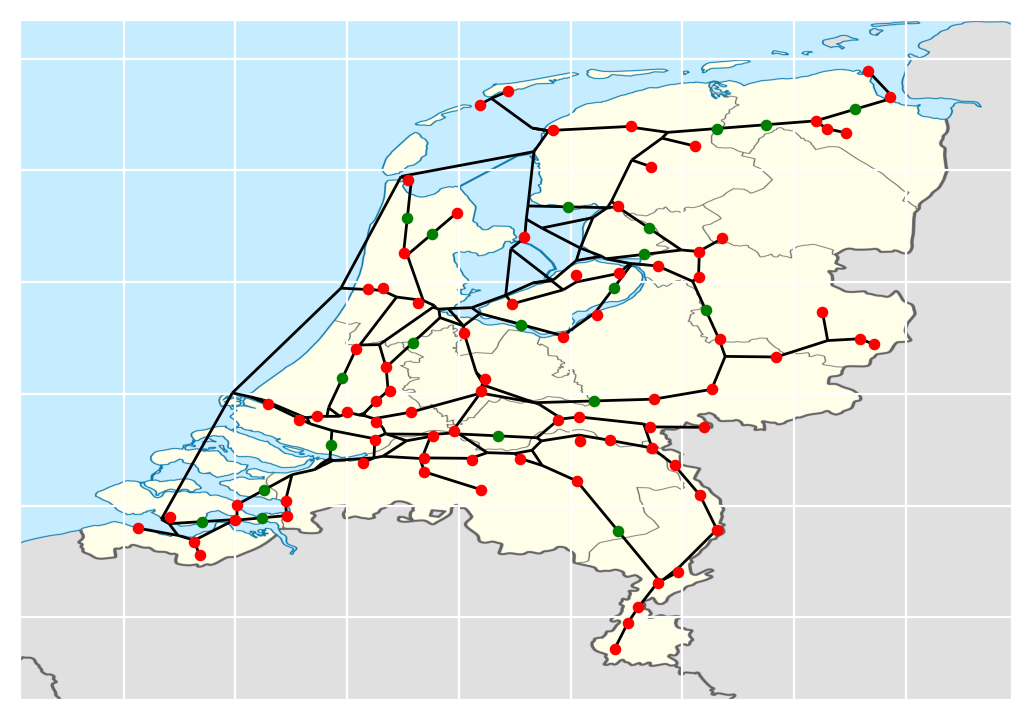

In [20]:
#check if it worked
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(dpi=200)
m = Basemap(projection='merc',
            llcrnrlon=3.31497114423,
            llcrnrlat=50.803721015,
            urcrnrlon=7.09205325687,
            urcrnrlat=53.5104033474,
            lat_0=(3.31497114423 + 7.09205325687) / 2,
            lon_0=(50.8 + 53.5104033474) / 2,
            resolution='i'
            )
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#D3D3D3', lake_color='aqua')
m.drawcoastlines()
m.drawcountries()

pos_dict = {}
mx, my = m(df_nodes.X.values, df_nodes.Y.values)
for count, elem in enumerate(df_nodes.n):
    pos_dict[elem] = (mx[count], my[count])

nx.draw_networkx_edges(G, pos_dict)

nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='r', label='Harbour nodes')
nx.draw_networkx_nodes(G, pos_dict, inserted, node_size=10, node_color='g', label='Inserted nodes')

img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
# nx.draw_networkx_nodes(G, pos_dict, ['8866429'], node_size=10, node_color='g')

## Apply second algorithm to select intersections in the network

In [21]:
df_nodes['n']=df_nodes.index

In [22]:
harbours_ongoing_routes = df_nodes.loc[((df_nodes.n.isin(harbour_nodes))&(df_nodes.degree>1))|(df_nodes.n.str.len()<4)|(df_nodes.n.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))]

In [23]:
harbours_ongoing_routes

,n,X,Y,geometry,Wkt,degree
8863206,8863206,4.364492,51.899417,"{'type': 'Point', 'coordinates': (4.3644923055...",POINT (4.3644923055515097 51.8994168659774928),2
8861546,8861546,6.130920,52.020740,"{'type': 'Point', 'coordinates': (6.1309203223...",POINT (6.1309203223777713 52.0207400789759973),2
8863306,8863306,4.500173,51.918099,"{'type': 'Point', 'coordinates': (4.5001726004...",POINT (4.5001726004237899 51.9180994743076027),2
8866775,8866775,5.275508,51.710912,"{'type': 'Point', 'coordinates': (5.2755082297...",POINT (5.2755082297752702 51.7109120927941959),2
8863207,8863207,5.872436,51.976705,"{'type': 'Point', 'coordinates': (5.8724362593...",POINT (5.8724362593158004 51.9767047069275989),2
...,...,...,...,...,...,...
116,116,5.175535,51.812524,NaN,NaN,2
117,117,5.826475,52.624314,NaN,NaN,2
118,118,6.154990,53.187512,NaN,NaN,2
119,119,6.375755,53.204648,NaN,NaN,2


In [24]:
intersection_df = df_nodes.loc[(df_nodes.degree>2)&(~df_nodes.n.isin(harbour_nodes))]

In [25]:
def find_nearest_harbour(lon, lat, selected):
    harbours = df_nodes.loc[((df_nodes.n.isin(harbour_nodes))&(df_nodes.degree>1))|(df_nodes.n.str.len()<4)|(df_nodes.n.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))|(df_nodes.n.isin(selected))]
    x = lon
    y = lat
    dev = 0.5

    #find nodes within deviation
    #select nodes near
    selection = harbours.loc[(harbours.X.between(x-dev, x+dev)) & (harbours.Y.between(y-dev, y+dev))]

    # in some areas there are very few nodes, therefore iteratively increase range to look for nodes until at least one is found

    while len(selection) == 0:
        dev+=0.5
        selection = harbours.loc[(harbours.X.between(x-dev, x+dev)) & (harbours.Y.between(y-dev, y+dev))].index

    selection['dist'] = selection.apply(lambda m : (geopy.distance.geodesic((m.X,m.Y),(lon,lat))), axis=1)

    return selection.dist.min()


In [26]:
selected = []
while len(selected) < 20:
    intersection_df['dist_nearest_harbour'] = intersection_df.apply(lambda m: (find_nearest_harbour(m.X, m.Y, selected)), axis=1)
    faraway = intersection_df.sort_values('dist_nearest_harbour', ascending=False).head(1).n.to_list()
    selected += faraway

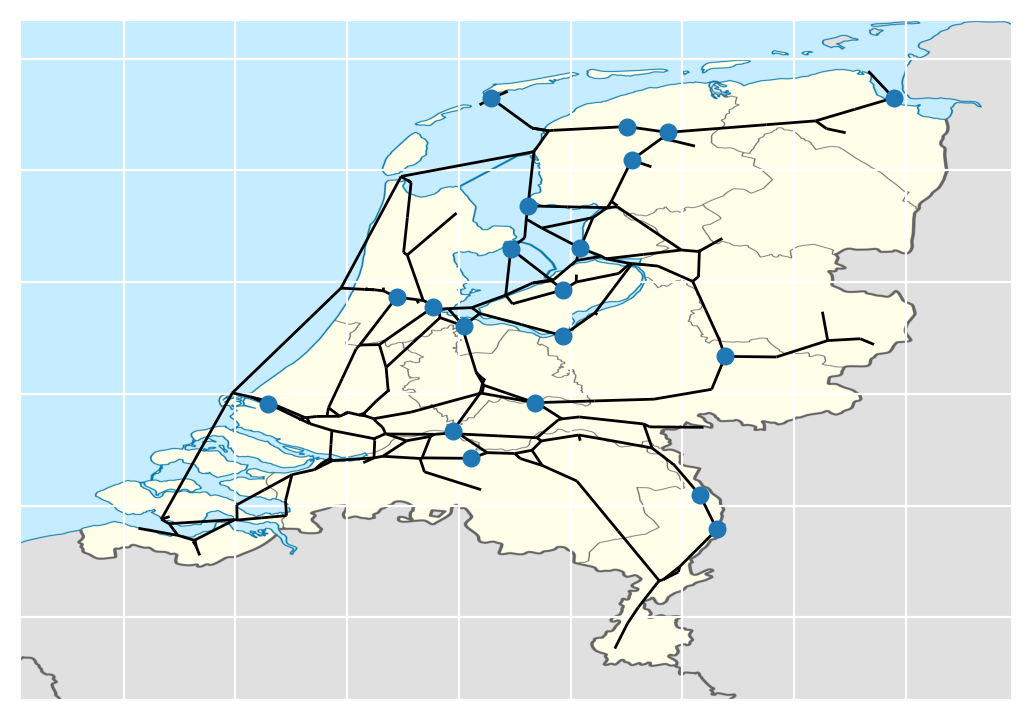

In [27]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, selected, node_size=30)

img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])

In [28]:
selected

['8865462',
 '8863114',
 '8860563',
 '8865887',
 '8861447',
 '8864526',
 '8860631',
 '8862048',
 '8863762',
 '8861611',
 '8861681',
 '8868065',
 '8863336',
 '8867910',
 '8860623',
 '8864952',
 '8865186',
 '8860918',
 '8864915',
 '8862907']

## Test functions

In [1]:
from generate_network import generate_network
from additional_intersections_new import additional_intersections

### Only additional intersections

In [9]:
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))

pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()
added_intersections = additional_intersections(G, 25)

['8861681', '8868065', '8867046', '8863114', '8861611', '8867516', '8861447', '8866727', '8865470', '8862907', '8860631', '8864915', '8862048', '8867489', '8863762'] intersections added


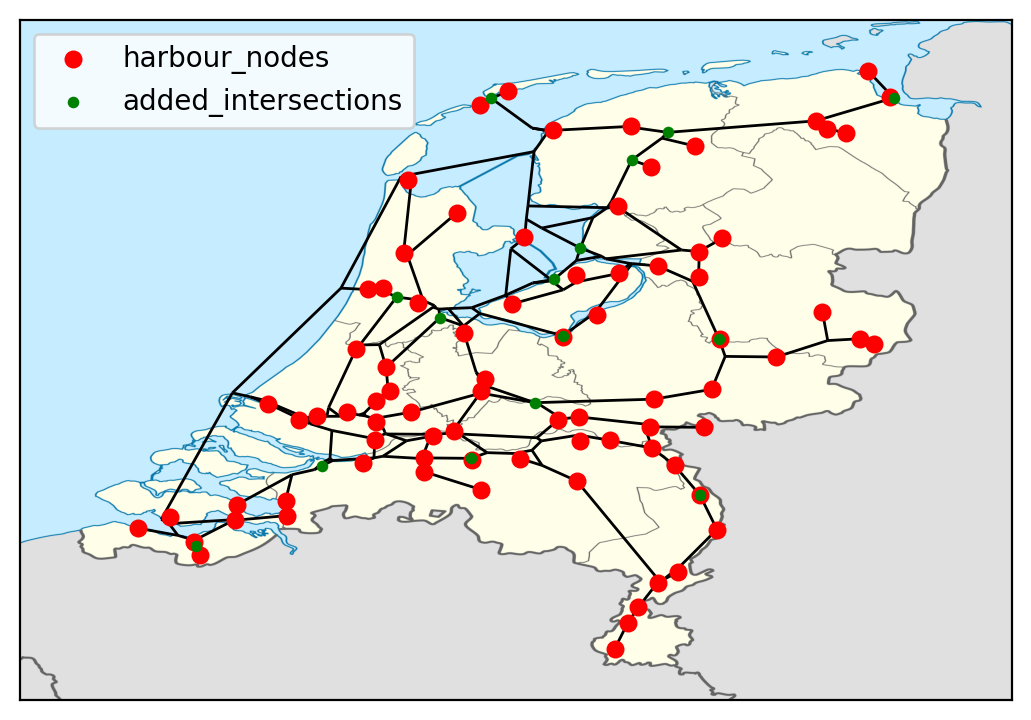

In [7]:
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(dpi=200)
m = Basemap(projection='merc',
            llcrnrlon=3.31497114423,
            llcrnrlat=50.803721015,
            urcrnrlon=7.09205325687,
            urcrnrlat=53.5104033474,
            lat_0=(3.31497114423 + 7.09205325687) / 2,
            lon_0=(50.8 + 53.5104033474) / 2,
            resolution='i'
            )
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#D3D3D3', lake_color='aqua')
m.drawcoastlines()
m.drawcountries()

pos_dict = {}
mx, my = m(df_nodes.X.values, df_nodes.Y.values)
for count, elem in enumerate(df_nodes.n):
    pos_dict[elem] = (mx[count], my[count])

nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_color='r', node_size=30, label='harbour_nodes')
nx.draw_networkx_nodes(G, pos_dict, added_intersections, node_color='g', node_size=10, label='added_intersections')
plt.legend()
plt.show()

## Only additional nodes

In [8]:
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
pos_dict = {}
paths = pickle.load(open('data/final_paths.p', "rb"))
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()
G, paths, inserted = generate_network(G, paths, 20)

pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

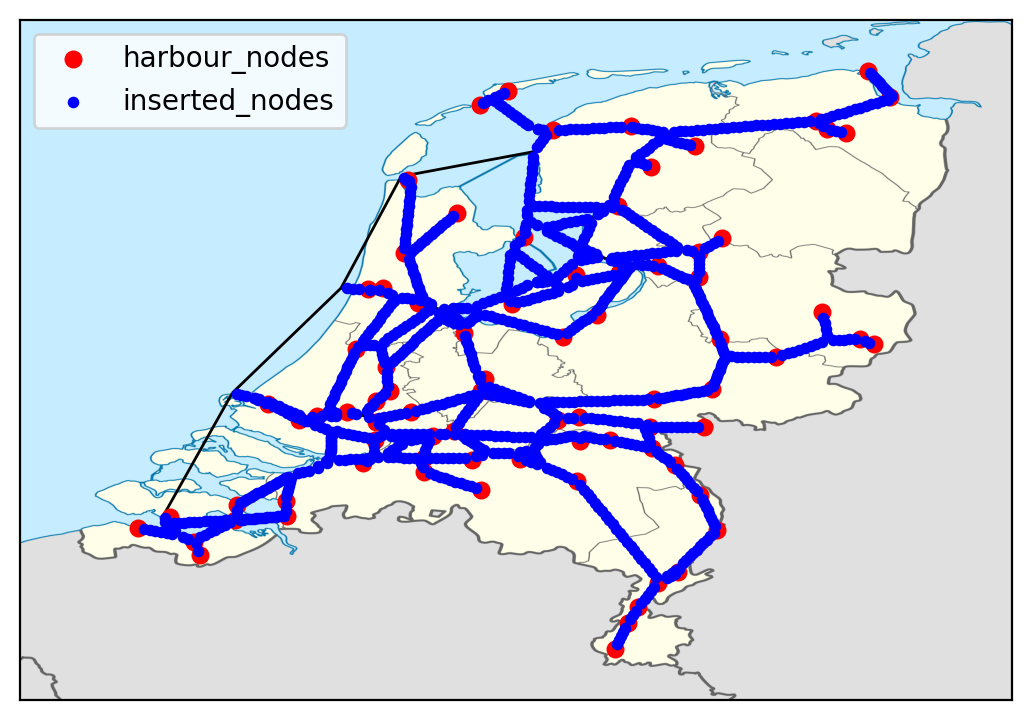

In [9]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_color='r', node_size=30, label='harbour_nodes')
nx.draw_networkx_nodes(G, pos_dict, inserted, node_color='b', node_size=10, label='inserted_nodes')

img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend()

## Both

In [9]:
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
pos_dict = {}
paths = pickle.load(open('data/final_paths.p', "rb"))
# for node in G.nodes:
#     pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()
G, paths, inserted = generate_network(G, paths, 25)
added_intersections = additional_intersections(G, 25)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_nodes['n'] = df_nodes.index

# pos_dict = {}
#
# for node in G.nodes:
#     pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

There were 25 nodes added, the longest remaining link is now: 35117.6542642193
['8863114', '8864435', '8865887', '8861447', '8864526', '8860631', '8863272', '8863762', '8861611', '8860623', '8864952', '8864915', '8860563', '8860918', '8862907', '8865462', '8860579', '8861863', '8866661', '8864151', '8864912', '8864258', '8861499', '8864553', '8865119'] intersections added


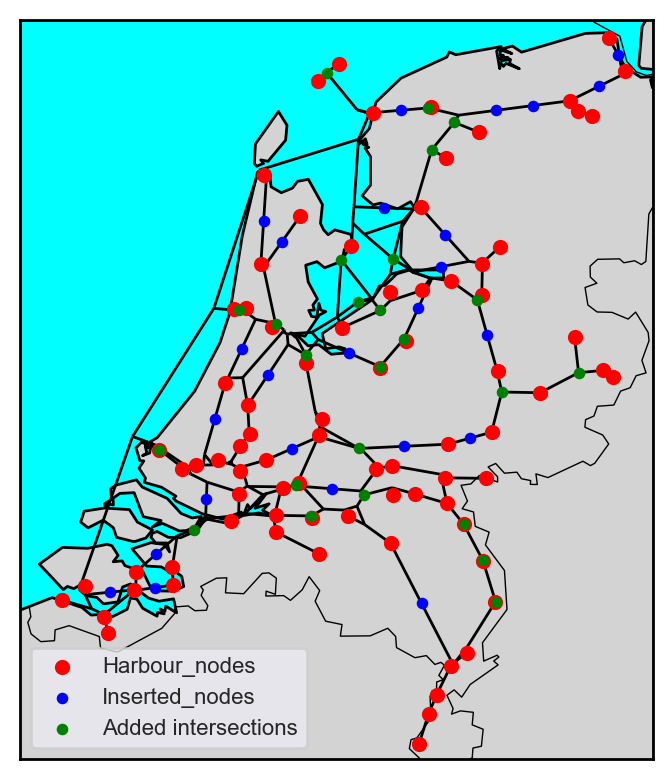

In [12]:
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(dpi=200)
m = Basemap(projection='merc',
            llcrnrlon=3.31497114423,
            llcrnrlat=50.803721015,
            urcrnrlon=7.09205325687,
            urcrnrlat=53.5104033474,
            lat_0=(3.31497114423 + 7.09205325687) / 2,
            lon_0=(50.8 + 53.5104033474) / 2,
            resolution='i'
            )
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#D3D3D3', lake_color='aqua')
m.drawcoastlines()
m.drawcountries()

pos_dict = {}
mx, my = m(df_nodes.X.values, df_nodes.Y.values)
for count, elem in enumerate(df_nodes.n):
    pos_dict[elem] = (mx[count], my[count])

nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_color='r', node_size=20, label='Harbour_nodes')
nx.draw_networkx_nodes(G, pos_dict, inserted, node_color='b', node_size=10, label='Inserted_nodes')
nx.draw_networkx_nodes(G, pos_dict, added_intersections, node_color='g', node_size=10, label='Added intersections')
plt.legend(fontsize=8)